In [1]:
import torch
from diffusers import StableDiffusionPipeline
from consistencydecoder import ConsistencyDecoder, save_image, load_image
import matplotlib.pyplot as plt

cdd = ConsistencyDecoder(device="cuda:0") # Model size: 2.49 GB

/home/pg51242/Desktop/text2img-gen/text2img_dm/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
cdd.ckpt


RecursiveScriptModule(
  original_name=ConvUNetVAE
  (blocks): RecursiveScriptModule(
    original_name=ModuleDict
    (embed_image): RecursiveScriptModule(
      original_name=ImageEmbedding
      (f): RecursiveScriptModule(original_name=Conv2d)
    )
    (embed_time): RecursiveScriptModule(
      original_name=TimestepEmbedding
      (f_1): RecursiveScriptModule(original_name=Affine)
      (f_2): RecursiveScriptModule(original_name=Affine)
    )
    (down_0_conv_0): RecursiveScriptModule(
      original_name=ConvResblock
      (gn_1): RecursiveScriptModule(original_name=GroupNorm)
      (f_1): RecursiveScriptModule(original_name=Conv2d)
      (f_2): RecursiveScriptModule(original_name=Conv2d)
      (f_t): RecursiveScriptModule(original_name=Affine)
      (gn_2): RecursiveScriptModule(original_name=ConditionalGroupNorm)
    )
    (down_0_conv_1): RecursiveScriptModule(
      original_name=ConvResblock
      (gn_1): RecursiveScriptModule(original_name=GroupNorm)
      (f_1): RecursiveS

In [25]:
torch.jit.save(cdd.ckpt, "cdd.pt")

In [45]:
# Check the sapes of the weights

(cdd.ckpt.blocks.embed_image.f.w.shape,
cdd.ckpt.blocks.down_0_conv_0.f_2.w.shape,
cdd.ckpt.blocks.down_1_conv_0.f_2.w.shape,
cdd.ckpt.blocks.down_3_conv_0.f_2.w.shape,
cdd.ckpt.blocks.mid_conv_0.f_2.w.shape)

(torch.Size([320, 7, 3, 3]),
 torch.Size([320, 320, 3, 3]),
 torch.Size([640, 640, 3, 3]),
 torch.Size([1024, 1024, 3, 3]),
 torch.Size([1024, 1024, 3, 3]))

In [49]:
(cdd.ckpt.blocks.embed_time.f_1.w.shape,
cdd.ckpt.blocks.embed_time.f_2.w.shape,
cdd.ckpt.blocks.down_0_conv_0.f_t.w.shape,
)

(torch.Size([1280, 320]), torch.Size([1280, 1280]), torch.Size([640, 1280]))

In [72]:
# Get the list of every layer
layer_names = [k for k in cdd.ckpt.state_dict()]
layer_names

['blocks.embed_image.f.w',
 'blocks.embed_image.f.b',
 'blocks.embed_time.f_1.w',
 'blocks.embed_time.f_1.b',
 'blocks.embed_time.f_2.w',
 'blocks.embed_time.f_2.b',
 'blocks.down_0_conv_0.gn_1.g',
 'blocks.down_0_conv_0.gn_1.b',
 'blocks.down_0_conv_0.f_1.w',
 'blocks.down_0_conv_0.f_1.b',
 'blocks.down_0_conv_0.f_2.w',
 'blocks.down_0_conv_0.f_2.b',
 'blocks.down_0_conv_0.f_t.w',
 'blocks.down_0_conv_0.f_t.b',
 'blocks.down_0_conv_0.gn_2.g',
 'blocks.down_0_conv_0.gn_2.b',
 'blocks.down_0_conv_1.gn_1.g',
 'blocks.down_0_conv_1.gn_1.b',
 'blocks.down_0_conv_1.f_1.w',
 'blocks.down_0_conv_1.f_1.b',
 'blocks.down_0_conv_1.f_2.w',
 'blocks.down_0_conv_1.f_2.b',
 'blocks.down_0_conv_1.f_t.w',
 'blocks.down_0_conv_1.f_t.b',
 'blocks.down_0_conv_1.gn_2.g',
 'blocks.down_0_conv_1.gn_2.b',
 'blocks.down_0_conv_2.gn_1.g',
 'blocks.down_0_conv_2.gn_1.b',
 'blocks.down_0_conv_2.f_1.w',
 'blocks.down_0_conv_2.f_1.b',
 'blocks.down_0_conv_2.f_2.w',
 'blocks.down_0_conv_2.f_2.b',
 'blocks.down_0_co

In [74]:
# Organize layers by blocks
model_structure = {}
for name in layer_names:
    split = name.split(".")
    if not split[1] in model_structure:
        model_structure[split[1]] = []

    model_structure[split[1]].append(split[2])
    model_structure[split[1]] = list(set(model_structure[split[1]]))

model_structure

{'embed_image': ['f'],
 'embed_time': ['f_2', 'f_1'],
 'down_0_conv_0': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_0_conv_1': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_0_conv_2': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_0_downsamp': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_1_conv_0': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1', 'f_s'],
 'down_1_conv_1': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_1_conv_2': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_1_downsamp': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_2_conv_0': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1', 'f_s'],
 'down_2_conv_1': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_2_conv_2': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_2_downsamp': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_3_conv_0': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_3_conv_1': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'down_3_conv_2': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'mid_conv_0': ['gn_1', 'gn_2', 'f_2', 'f_t', 'f_1'],
 'mid_conv_1': ['

In [141]:
# Create instantiate each layer and replace the default weights with the pretrained ones
layers = {}
for key in model_structure.keys():
    layers[key] = {}
    for layer in model_structure[key]:

        if layer.startswith("gn"): # ResBlock GroupNorm
            full_key = "blocks." + key + "." + layer + ".g"
            full_key_bias = "blocks." + key + "." + layer + ".b"
            l = nn.GroupNorm(num_channels=cdd.ckpt.state_dict()[full_key].shape[0], num_groups=32)
            l.weight = nn.Parameter(cdd.ckpt.state_dict()[full_key].cpu().float())
            l.bias = nn.Parameter(cdd.ckpt.state_dict()[full_key_bias].cpu().float())
        else:
            full_key = "blocks." + key + "." + layer + ".w"
            in_ch = cdd.ckpt.state_dict()[full_key].shape[1]
            out_ch = cdd.ckpt.state_dict()[full_key].shape[0]

            if layer.endswith("_t") or key == "embed_time": # Timestep embed layers
                full_key_bias = "blocks." + key + "." + layer + ".b"
                l = nn.Linear(in_ch, out_ch)
                l.weight = nn.Parameter(cdd.ckpt.state_dict()[full_key].cpu().float())
                l.bias = nn.Parameter(cdd.ckpt.state_dict()[full_key_bias].cpu().float())
                
            elif layer.endswith("_s"): # ResBlock skip
                full_key_bias = "blocks." + key + "." + layer + ".b"
                l = nn.Conv2d(in_ch, out_ch, kernel_size=(cdd.ckpt.state_dict()[full_key].shape[2], cdd.ckpt.state_dict()[full_key].shape[3]), padding=0, stride=1)
                l.weight = nn.Parameter(cdd.ckpt.state_dict()[full_key].cpu().float())
                l.bias = nn.Parameter(cdd.ckpt.state_dict()[full_key_bias].cpu().float())

            elif layer.startswith("f"): # ResBlock Conv
                full_key_bias = "blocks." + key + "." + layer + ".b"
                l = nn.Conv2d(in_ch, out_ch, kernel_size=(cdd.ckpt.state_dict()[full_key].shape[2], cdd.ckpt.state_dict()[full_key].shape[3]), stride=1, padding=1)
                l.weight = nn.Parameter(cdd.ckpt.state_dict()[full_key].cpu().float())
                l.bias = nn.Parameter(cdd.ckpt.state_dict()[full_key_bias].cpu().float())

        # layers.append(l)
        layers[key][layer] = l

    
layers



{'embed_image': {'f': Conv2d(7, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))},
 'embed_time': {'f_2': Linear(in_features=1280, out_features=1280, bias=True),
  'f_1': Linear(in_features=320, out_features=1280, bias=True)},
 'down_0_conv_0': {'gn_1': GroupNorm(32, 320, eps=1e-05, affine=True),
  'gn_2': GroupNorm(32, 320, eps=1e-05, affine=True),
  'f_2': Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  'f_t': Linear(in_features=1280, out_features=640, bias=True),
  'f_1': Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))},
 'down_0_conv_1': {'gn_1': GroupNorm(32, 320, eps=1e-05, affine=True),
  'gn_2': GroupNorm(32, 320, eps=1e-05, affine=True),
  'f_2': Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  'f_t': Linear(in_features=1280, out_features=640, bias=True),
  'f_1': Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))},
 'down_0_conv_2': {'gn_1': GroupNorm(32, 320, eps=1e-05, affine=True),
  '

In [115]:
layers["down_1_conv_0"]["f_1"].in_channels, layers["down_1_conv_0"]["f_1"].out_channels, layers["down_1_conv_0"]["f_t"].in_features, layers["down_1_conv_0"]["f_t"].out_features

(320, 640, 1280, 1280)

In [158]:
from sgm.modules.diffusionmodules.openaimodel import ResBlock, TimestepEmbedSequential

In [140]:
# Convert the single layers into ResBlocks
layer_blocks = {}
for key in layers.keys():
    if "conv" in key or "upsamp" in key or "downsamp" in key:
        block = layers[key]
        resblock = ResBlock(
            block["f_1"].in_channels,
            block["f_t"].in_features,
            0.0,
            out_channels=block["f_1"].out_channels,
            up="upsamp" in key,
            down="downsamp" in key,
            use_checkpoint=True,
            use_scale_shift_norm=True
        )
        
        # First block
        resblock.in_layers[0] = block["gn_1"]
        resblock.in_layers[2] = block["f_1"]

        # Second block
        resblock.out_layers[0] = block["gn_2"]
        resblock.out_layers[3] = block["f_2"]

        # Timestep embeddings
        resblock.emb_layers[1] = block["f_t"]

        # Skip-connection Conv
        if "f_s" in block.keys():
            resblock.skip_connection = block["f_s"]

        layer_blocks[key] = resblock

layer_blocks.keys()

dict_keys(['down_0_conv_0', 'down_0_conv_1', 'down_0_conv_2', 'down_0_downsamp', 'down_1_conv_0', 'down_1_conv_1', 'down_1_conv_2', 'down_1_downsamp', 'down_2_conv_0', 'down_2_conv_1', 'down_2_conv_2', 'down_2_downsamp', 'down_3_conv_0', 'down_3_conv_1', 'down_3_conv_2', 'mid_conv_0', 'mid_conv_1', 'up_3_conv_0', 'up_3_conv_1', 'up_3_conv_2', 'up_3_conv_3', 'up_3_upsamp', 'up_2_conv_0', 'up_2_conv_1', 'up_2_conv_2', 'up_2_conv_3', 'up_2_upsamp', 'up_1_conv_0', 'up_1_conv_1', 'up_1_conv_2', 'up_1_conv_3', 'up_1_upsamp', 'up_0_conv_0', 'up_0_conv_1', 'up_0_conv_2', 'up_0_conv_3'])

In [151]:
# Create the remaining non-ResBlocks
layer_blocks["embed_image"] = layers["embed_image"]["f"]
layer_blocks["embed_time"] = nn.Sequential(
    layers["embed_time"]["f_1"],
    nn.SiLU(),
    layers["embed_time"]["f_2"],
)
layer_blocks["output"] = nn.Sequential(
    layers["output"]["gn"],
    nn.SiLU(),
    layers["output"]["f"],
)


In [155]:
print("Every layer block is set:", sorted(list(layer_blocks.keys())) == sorted(list(set([l.split(".")[1] for l in layer_names]))))

Every layer block is set: True


In [157]:
layer_blocks

{'down_0_conv_0': ResBlock(
   (in_layers): Sequential(
     (0): GroupNorm(32, 320, eps=1e-05, affine=True)
     (1): SiLU()
     (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   )
   (h_upd): Identity()
   (x_upd): Identity()
   (emb_layers): Sequential(
     (0): SiLU()
     (1): Linear(in_features=1280, out_features=640, bias=True)
   )
   (out_layers): Sequential(
     (0): GroupNorm(32, 320, eps=1e-05, affine=True)
     (1): SiLU()
     (2): Dropout(p=0.0, inplace=False)
     (3): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   )
   (skip_connection): Identity()
 ),
 'down_0_conv_1': ResBlock(
   (in_layers): Sequential(
     (0): GroupNorm(32, 320, eps=1e-05, affine=True)
     (1): SiLU()
     (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   )
   (h_upd): Identity()
   (x_upd): Identity()
   (emb_layers): Sequential(
     (0): SiLU()
     (1): Linear(in_features=1280, out_features=640, bias=True)
   )
 

In [159]:
sorted(list(layer_blocks.keys()))

['down_0_conv_0',
 'down_0_conv_1',
 'down_0_conv_2',
 'down_0_downsamp',
 'down_1_conv_0',
 'down_1_conv_1',
 'down_1_conv_2',
 'down_1_downsamp',
 'down_2_conv_0',
 'down_2_conv_1',
 'down_2_conv_2',
 'down_2_downsamp',
 'down_3_conv_0',
 'down_3_conv_1',
 'down_3_conv_2',
 'embed_image',
 'embed_time',
 'mid_conv_0',
 'mid_conv_1',
 'output',
 'up_0_conv_0',
 'up_0_conv_1',
 'up_0_conv_2',
 'up_0_conv_3',
 'up_1_conv_0',
 'up_1_conv_1',
 'up_1_conv_2',
 'up_1_conv_3',
 'up_1_upsamp',
 'up_2_conv_0',
 'up_2_conv_1',
 'up_2_conv_2',
 'up_2_conv_3',
 'up_2_upsamp',
 'up_3_conv_0',
 'up_3_conv_1',
 'up_3_conv_2',
 'up_3_conv_3',
 'up_3_upsamp']

In [167]:
down_blocks = nn.ModuleList([
    TimestepEmbedSequential(layer_blocks["down_0_conv_0"]),
    TimestepEmbedSequential(layer_blocks["down_0_conv_1"]),
    TimestepEmbedSequential(layer_blocks["down_0_conv_2"]),
    TimestepEmbedSequential(layer_blocks["down_0_downsamp"]),
    TimestepEmbedSequential(layer_blocks["down_1_conv_0"]),
    TimestepEmbedSequential(layer_blocks["down_1_conv_1"]),
    TimestepEmbedSequential(layer_blocks["down_1_conv_2"]),
    TimestepEmbedSequential(layer_blocks["down_1_downsamp"]),
    TimestepEmbedSequential(layer_blocks["down_2_conv_0"]),
    TimestepEmbedSequential(layer_blocks["down_2_conv_1"]),
    TimestepEmbedSequential(layer_blocks["down_2_conv_2"]),
    TimestepEmbedSequential(layer_blocks["down_2_downsamp"]),
    TimestepEmbedSequential(layer_blocks["down_3_conv_0"]),
    TimestepEmbedSequential(layer_blocks["down_3_conv_1"]),
    TimestepEmbedSequential(layer_blocks["down_3_conv_2"]),
])

mid_blocks = TimestepEmbedSequential(
    layer_blocks["mid_conv_0"],
    layer_blocks["mid_conv_1"]
)

up_blocks = nn.ModuleList([
    TimestepEmbedSequential(layer_blocks["up_3_conv_0"]),
    TimestepEmbedSequential(layer_blocks["up_3_conv_1"]),
    TimestepEmbedSequential(layer_blocks["up_3_conv_2"]),
    TimestepEmbedSequential(layer_blocks["up_3_conv_3"],
        layer_blocks["up_3_upsamp"]),
    TimestepEmbedSequential(layer_blocks["up_2_conv_0"]),
    TimestepEmbedSequential(layer_blocks["up_2_conv_1"]),
    TimestepEmbedSequential(layer_blocks["up_2_conv_2"]),
    TimestepEmbedSequential(layer_blocks["up_2_conv_3"],
        layer_blocks["up_2_upsamp"]),
    TimestepEmbedSequential(layer_blocks["up_1_conv_0"]),
    TimestepEmbedSequential(layer_blocks["up_1_conv_1"]),
    TimestepEmbedSequential(layer_blocks["up_1_conv_2"]),
    TimestepEmbedSequential(layer_blocks["up_1_conv_3"],
        layer_blocks["up_1_upsamp"]),
    TimestepEmbedSequential(layer_blocks["up_0_conv_0"]),
    TimestepEmbedSequential(layer_blocks["up_0_conv_1"]),
    TimestepEmbedSequential(layer_blocks["up_0_conv_2"]),
    TimestepEmbedSequential(layer_blocks["up_0_conv_3"]),
])

output = layer_blocks["output"]

In [195]:
from typing import Optional
import torch.nn.functional as F
from sgm.modules.diffusionmodules.util import timestep_embedding


# Put all of the blocks together in the model

class DiffusionDecoder(nn.Module):
    def __init__(self,
        model_channels: int,
        dropout: float = 0.0,
        use_checkpoint: bool = False,
        use_scale_shift_norm: bool = True,
        scaling_factor: float = 0.18215
    ):
        super().__init__()
        self.model_channels = model_channels
        self.input = nn.Identity()
        self.time_embed = nn.Identity()
        self.down_blocks = nn.ModuleList([])
        self.middle_block = nn.ModuleList([])
        self.up_blocks = nn.ModuleList([])
        self.output = nn.Identity()

        pass

    def forward(self,
        x: torch.Tensor,
        timesteps: Optional[torch.Tensor] = None,
        context: Optional[torch.Tensor] = None,
        y: Optional[torch.Tensor] = None
    ):
        # Upscale latent
        upscale_factor = 2 ** (4-1)
        z = F.interpolate(context, mode="nearest", scale_factor=upscale_factor)
        h = torch.cat([x, z], dim=1)

        time_embeddings = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        embeddings = self.time_embed(time_embeddings)

        h = self.input(h)

        # h = x
        hs = [h]

        for module in self.down_blocks:
            h = module(h, embeddings)
            hs.append(h)

        h = self.middle_block(h, embeddings)

        for module in self.up_blocks:
            h = module(torch.cat([h, hs.pop()], dim=1), embeddings)

        return self.output(h)

In [196]:
df = DiffusionDecoder(320)
df.down_blocks = down_blocks.cuda()
df.middle_block = mid_blocks.cuda()
df.up_blocks = up_blocks.cuda()
df.output = output.cuda()
df.time_embed = layer_blocks["embed_time"].cuda()
df.input = layer_blocks["embed_image"].cuda()

cuda:0 cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


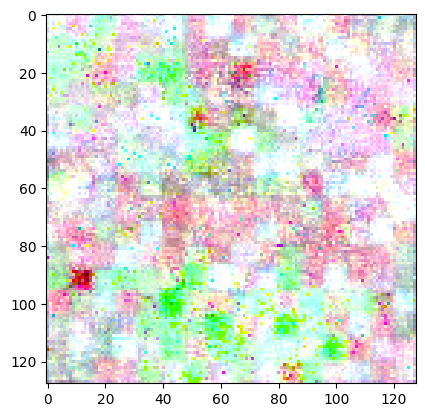

In [205]:
latent = torch.load("datasets/imagenet/latents_train/n01440764/n01440764_18.pt").unsqueeze(dim=0).to("cuda")
shape = (latent.size(0), 3, 8 * latent.size(2), 8 * latent.size(3))
noise = torch.zeros(shape, device=cdd.device, dtype=latent.dtype)
noise = torch.randn_like(noise)

print(noise.device, latent.device)
with torch.cuda.amp.autocast():
    out = df(
        noise.cuda().float(),
        torch.Tensor([16]).cuda().float(),
        context=latent.cuda().float())

    B, C = noise.shape[:2]
    model_output, _ = torch.split(out, C, dim=1)
    model_output = model_output.float().clamp(-1, 1)
    _ = _.float().clamp(-1, 1)

    npimg = model_output[0].cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

    npimg = _[0].cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

In [207]:
torch.save(df.state_dict(), "cdd_custom.pt")

: 